# Variational Bayes for Gaussian Mixture Models using ADVI

We use the BIJAX library (https://github.com/patel-zeel/bijax).
For a TFP implementation, see
https://github.com/probml/pyprobml/blob/master/notebooks/book2/10/vb_gmm.ipynb

In [12]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

try:
    import optax
except:
    %pip install optax
    import optax

import jax
import jax.numpy as jnp
from functools import partial

try:
    from bijax.advi import ADVI
except ModuleNotFoundError:
    %pip install git+https://github.com/patel-zeel/bijax.git
    from bijax.advi import ADVI

from bijax.map import MAP

try:
    from probml_utils.plotting import savefig, latexify
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils.plotting import savefig, latexify

from bijax.utils import train_fn

from jax.config import config

config.update("jax_enable_x64", True)

latexify(width_scale_factor=2, fig_height=2)

## Helper functions for plotting

In [13]:
def plot_loc_scale(weight_, loc_, scale_tril_, color, ax):
    cov = np.dot(scale_tril_, scale_tril_.T)
    w, v = np.linalg.eig(cov)
    angle = np.arctan2(v[1, 0], v[1, 1]) * 360 / (2 * np.pi)
    height = 3 * np.sqrt(w[1])  # minor axis
    width = 3 * np.sqrt(w[0])  # major axis

    e = Ellipse(xy=loc_, width=width, height=height, angle=angle)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(weight_)
    e.set_facecolor(color)
    e.set_edgecolor("black")


def plot_posterior_with_data(posterior_sample, data, ax, facecolors=None):
    loc_ = posterior_sample["loc"]
    ax.plot(data[:, 0], data[:, 1], "k.", markersize=3, label="data")
    ax.plot(loc_[:, 0], loc_[:, 1], "r^", markersize=3, label="loc")

    np.random.seed(420)
    if facecolors is None:
        facecolors = sns.color_palette("deep", n_colors=ncomponents)

    weights_ = np.power(posterior_sample["mixture_weights"], 0.8)  # larger power means less emphasis on low weights
    weights_ = weights_ * (0.5 / np.max(weights_))
    scale_tril = posterior_sample["scale"][:, jnp.newaxis] * posterior_sample["correlation_tril"]
    for i, (weight_, l_, st_) in enumerate(zip(weights_, loc_, scale_tril)):
        plot_loc_scale(weight_, l_, st_, color=facecolors[i], ax=ax)

    ax.legend()


def plot_posterior_sample(posterior_sample, data, seed):
    fig, ax = plt.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]})
    plot_posterior_with_data(posterior_sample, data=data, ax=ax[0])

    sns.barplot(
        y=np.arange(ncomponents), x=posterior_sample["mixture_weights"], ax=ax[1], palette="deep", orient="horizontal"
    )
    ax[1].set_ylabel("Mixture components")
    ax[1].set_xlabel("Weights")
    sns.despine()

### Load data

(272, 2)


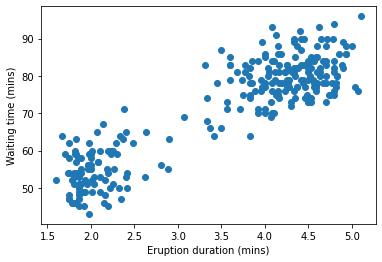

In [14]:
data_url = "https://raw.githubusercontent.com/probml/probml-data/main/data/faithful.txt"
data = np.array(np.loadtxt(data_url))
print(data.shape)

plt.figure()
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel("Eruption duration (mins)")
plt.ylabel("Waiting time (mins)")

# Standardize the data (to simplify model fitting)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
data_normalized = (data - mean) / std

## Define model

In [15]:
ncomponents = 10
ndata = data.shape[0]
ndims = data.shape[1]

prior = {
    "mixture_weights": tfd.Dirichlet(concentration=jnp.ones(ncomponents)),
    "loc": tfd.Normal(loc=jnp.zeros((ncomponents, ndims)), scale=1.0),
    "scale": tfd.HalfNormal(scale=2 * jnp.ones((ncomponents, ndims))),
    "correlation_tril": tfd.CholeskyLKJ(dimension=ndims, concentration=jnp.ones(ncomponents)),
}

prior_constraints = {
    "mixture_weights": tfb.SoftmaxCentered(),
    "scale": tfb.Exp(),
    "correlation_tril": tfb.CorrelationCholesky(),
}


def likelihood_fn(params, inputs):
    scale_tril = params["scale"][:, jnp.newaxis] * params["correlation_tril"]
    mixture_distribution = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=params["mixture_weights"]),
        components_distribution=tfd.MultivariateNormalTriL(loc=params["loc"], scale_tril=scale_tril),
    )
    return mixture_distribution

## MAP estimation

In [16]:
map_estimator = MAP(prior, likelihood_fn, prior_constraints)

In [29]:
seed = jax.random.PRNGKey(123)
initial_params = map_estimator.init(seed)
optimizer = optax.adam(learning_rate=0.1)

loss_fn = jax.tree_util.Partial(map_estimator.neg_log_joint, outputs=data_normalized)

seed = jax.random.PRNGKey(321)

results = train_fn(loss_fn, initial_params, optimizer, n_epochs=100)

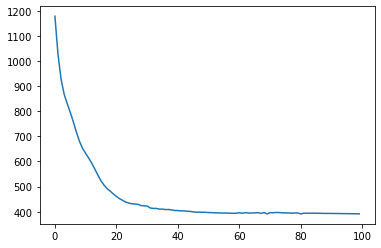

In [30]:
plt.plot(results["losses"]);

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


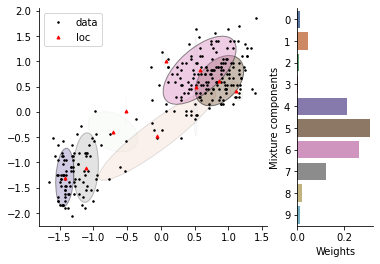

In [31]:
learned_params = map_estimator.apply(results["params"])

plot_posterior_sample(learned_params, data=data_normalized, seed=seed)
savefig(f"vb_gmm_map_sample")

## ADVI

In [4]:
model = ADVI(prior, likelihood_fn, prior_constraints)

In [5]:
seed = jax.random.PRNGKey(123)
params = model.init(seed)

loss_fn = partial(model.loss_fn, outputs=data_normalized, inputs=None, full_data_size=ndata, n_samples=100)

tx = optax.adam(learning_rate=2e-2)
seed = jax.random.PRNGKey(1)
results = train_fn(loss_fn, params, tx, n_epochs=1000, seed=seed, return_args={"losses"})

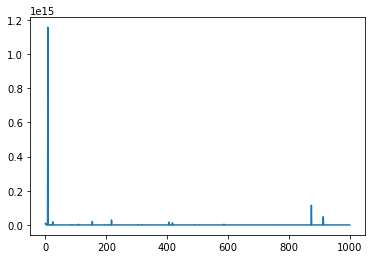

In [6]:
plt.plot(results["losses"]);

In [8]:
surrogate_posterior = model.get_params_posterior(results["params"])

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


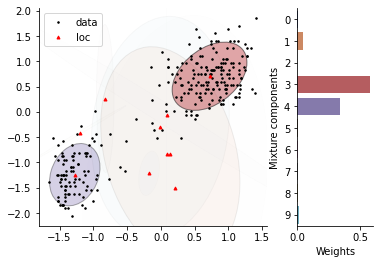

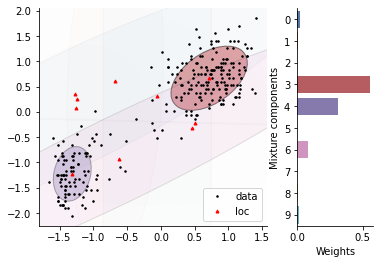

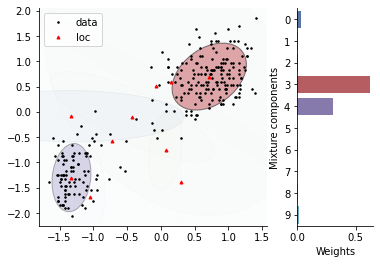

In [9]:
for seed_idx, seed in enumerate([12, 34, 56]):
    seed = jax.random.PRNGKey(seed)
    posterior_sample = surrogate_posterior.sample(seed=seed)
    plot_posterior_sample(posterior_sample, data=data_normalized, seed=seed)
    savefig(f"vb_gmm_bayes_sample{seed_idx}")

In [10]:
seed = jax.random.PRNGKey(1234)
sample = surrogate_posterior.sample(seed=seed)
jax.tree_map(lambda x: x.shape, sample)

{'correlation_tril': (10, 2, 2),
 'loc': (10, 2),
 'mixture_weights': (10,),
 'scale': (10, 2)}